## Neural networks for segmentation

In [1]:
# ! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
# ! unzip -q data.zip

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [2]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/home/viktor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/home/viktor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


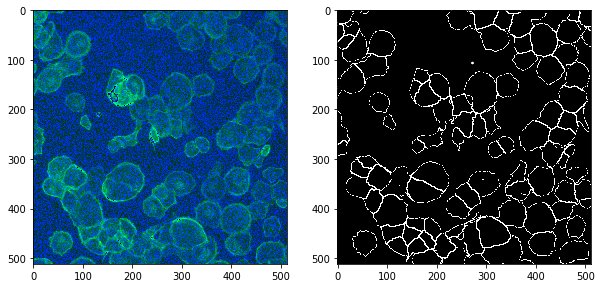

In [3]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = sp.misc.imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [4]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [5]:
import torch
from torchvision import transforms as T, models as M
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os, glob, time, copy, random
from PIL import Image

In [6]:
class CancerCellDataset(Dataset):
    def __init__(self, image_path, mask_path, image_transform=None, mask_transform=None):
        super(CancerCellDataset, self).__init__()
        
        # Get sorted image/mask paths.
        images = glob.glob(os.path.join(image_path, '*.bmp'))
        masks = glob.glob(os.path.join(mask_path, '*.png'))
        
        # Sort filenames to 
        images.sort()
        masks.sort()
        
        self.data = list(zip(images, masks))
        
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __getitem__(self, idx):
        image_path, mask_path = self.data[idx]
        
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        
        # "Synchronize" transformation of images and masks using same random seed.
        seed = np.random.randint(2147483647)
        if self.image_transform is not None:
            random.seed(seed)
            image = self.image_transform(image)
        if self.mask_transform is not None:
            random.seed(seed)
            mask = self.mask_transform(mask)
        
        mask = (mask > 0).float()
        return image, mask

    def __len__(self):
        return len(self.data)

In [7]:
# Prepare the data
# Some code parts may be stylized as in, or be directly from https://pytorch.org/tutorials/index.html

image_dir = './BBBC018_v1_images-fixed/'
mask_dir = './BBBC018_v1_outlines/'

stages = ['train', 'val']

# Transforms applied to training image/mask with the same random seed
synchronous_transforms = T.Compose([T.RandomHorizontalFlip(),
                                    T.RandomVerticalFlip()
#                                     T.RandomAffine(180, (.2, .2), (.8, 1.2), 20, Image.BILINEAR)
                                   ])

image_transforms = {
    'train': T.Compose([synchronous_transforms,
                        T.ColorJitter(brightness=0.2, contrast=0.2),
                        T.ToTensor()]),
    'val'  : T.ToTensor()}
mask_transforms = {
    'train': T.Compose([synchronous_transforms,
                        T.ToTensor()]),
    'val'  : T.ToTensor()}


datasets = {stage: CancerCellDataset(os.path.join(image_dir, stage),
                                     os.path.join(mask_dir, stage),
                                     image_transform=image_transforms[stage],
                                     mask_transform=mask_transforms[stage])
            for stage in stages}

batch_sizes = {'train': 3, 'val': 3}
drop_shuffle = {'train': True, 'val': False}
dataloaders = {stage: torch.utils.data.DataLoader(datasets[stage],
                                                  batch_size=batch_sizes[stage],
                                                  shuffle=drop_shuffle[stage],
                                                  num_workers=32,
                                                  drop_last=drop_shuffle[stage])
               for stage in stages}

dataset_sizes = {stage: len(datasets[stage]) for stage in stages}

device = torch.device("cuda:0")

In [8]:
# U-net from the paper https://arxiv.org/pdf/1505.04597.pdf
# Implementated using some ideas from 
# https://github.com/milesial/Pytorch-UNet and https://github.com/ternaus/TernausNet

class DoubleConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv2d, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class Down(nn.Module):
    def __init__(self, in_channels):
        super(Down, self).__init__()
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.double_conv = DoubleConv2d(in_channels, in_channels*2)
    
    def forward(self, x):
        x = self.max_pool(x)
        x = self.double_conv(x)
        return x

class Up(nn.Module):
    def __init__(self, in_channels):
        super(Up, self).__init__()
        self.pad = nn.ZeroPad2d((0,1,0,1))
        self.conv_up = nn.Conv2d(in_channels, in_channels//2, kernel_size=2)
        self.relu = nn.ReLU()
        self.double_conv = DoubleConv2d(in_channels, in_channels//2)
    
    def forward(self, x, copy):
        # Up-Convolution
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = self.pad(x)
        x = self.relu(self.conv_up(x))

        # Concatenate
        x = torch.cat([copy, x], dim=1)
        
        # Two Conv layers
        x = self.double_conv(x)
        return x
    
class UNet(nn.Module):
    def __init__(self, pretrained_encoder=False):
        super(UNet, self).__init__()
        self.inp = DoubleConv2d(3, 64)
        self.down1 = Down(64)
        self.down2 = Down(128)
        self.down3 = Down(256)
        self.down4 = Down(512)
        self.up1 = Up(1024)
        self.up2 = Up(512)
        self.up3 = Up(256)
        self.up4 = Up(128)
        self.out = nn.Conv2d(64, 1, kernel_size=1)
        
        if pretrained_encoder == True:
            # Load some layers from pretrained vgg13_bn.
            encoder = M.vgg13_bn(pretrained=True).features
            
            blocks = [self.inp, self.down1, self.down2, self.down3]
            first_indexes = [0, 7, 14, 21]
            for i, block in zip(first_indexes, blocks): 
                block.conv1 = encoder[i]
                block.bn1 = encoder[i+1]
                block.conv2 = encoder[i+2]
                block.bn2 = encoder[i+3]
            
    def forward(self, x):
        x1 = self.inp(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.out(x)
        return x

In [9]:
# Training loop
loss_history = {'train': [], 'val': []}
best_acc = 0.0

def train_model(model, criterion, optimizer, scheduler, num_epochs=10,  acc=0.0):
    since = time.time()

    global best_model
    best_model = copy.deepcopy(model.state_dict())
    
    global best_acc
    best_acc = acc

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            since_epoch = time.time()
        
            # Set the model mode
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            predictions = []
            ground_truths = []

            # Iterate over data.
            for inputs, masks in dataloaders[phase]:
                inputs = inputs.to(device)
                masks = masks.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    optimizer.zero_grad()
                    
                    if hasattr(criterion, '__name__') and criterion.__name__ == 'jaccard_loss':
                        loss = criterion(masks.long(), outputs)
                    else:
                        loss = criterion(outputs.view(-1), masks.view(-1))
    
                    if phase == 'train':  
                        loss.backward()
                        optimizer.step()              

                # statistics
                batch_size = inputs.size(0)
                running_loss += loss.item() * batch_size
                # Store masks to calculate IoU for the whole epoch
                predicted_mask = (outputs.detach() >= 0).cpu().numpy()
                masks = masks.cpu().numpy()
                predictions.append(predicted_mask)
                ground_truths.append(masks)
            
            # Verbose
            epoch_loss = running_loss / dataset_sizes[phase]
            predictions = np.concatenate(predictions)
            ground_truths = np.concatenate(ground_truths)
            epoch_iou = calc_iou(predictions, ground_truths)
            print('{} Loss: {:.4f} IoU: {:.4f} Time: {:.1f} sec'.format(
                phase, epoch_loss, epoch_iou, time.time() - since_epoch))
            
            loss_history[phase].append(epoch_loss)

            # deep copy the model
            if phase == 'val':
                if epoch_iou > best_acc:
                    best_acc = epoch_iou
                    best_model = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val IoU: {:4f}'.format(best_acc))

    model.load_state_dict(best_model)
    return model

In [10]:
def maskshow(i=0):
    """Visualize predicted mask probabilities, predicted mask, 
    and ground truth mask for a validation smaple.
    Args:
        i: number of validation sample.
    """
    inp, mask = datasets['val'][i]
    out = net(inp.to(device)[None,...])

    mask_pred = out[0,0].detach().sigmoid().cpu().numpy()
    mask = mask[0].cpu().numpy()
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(mask_pred, 'gray', vmax=1, vmin=0)
    plt.subplot(1,3,2)
    plt.imshow(mask_pred.round(), 'gray', vmax=1, vmin=0)
    plt.subplot(1,3,3)
    plt.imshow(mask, 'gray', vmax=1, vmin=0)

In [11]:
# Jaccard Loss - code from https://github.com/kevinzakka/pytorch-goodies/blob/master/losses.py
# From the paper - https://www.cs.toronto.edu/~urtasun/publications/mattyus_etal_iccv17.pdf
def jaccard_loss(true, logits, eps=1e-7):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the jaccard loss so we
    return the negated jaccard loss.
    Args:
        true: a tensor of shape [B, H, W] or [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        jacc_loss: the Jaccard loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(probas, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    union = cardinality - intersection
    jacc_loss = (intersection / (union + eps)).mean()
    return (1 - jacc_loss)

In [12]:
net = UNet(pretrained_encoder=True)
net = net.to(device)

# pos to neg in the train dataset is .961 : .039
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(10, dtype=torch.float32, device=device))
# criterion = jaccard_loss

optimizer = optim.SGD(net.parameters(), lr=.1, momentum=0.9, weight_decay=0.0001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

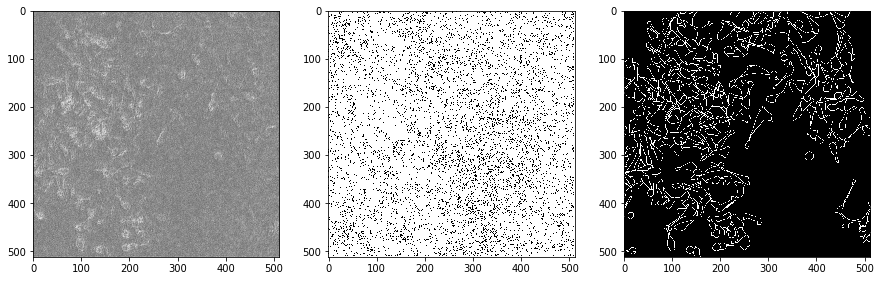

In [13]:
# Network output before training
maskshow(3)

In [14]:
net = train_model(net, criterion, optimizer, scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.6347 IoU: 0.0961 Time: 13.8 sec
val Loss: 0.9743 IoU: 0.0000 Time: 1.7 sec

Epoch 1/49
----------
train Loss: 0.4730 IoU: 0.1703 Time: 13.7 sec
val Loss: 0.6877 IoU: 0.1963 Time: 1.7 sec

Epoch 2/49
----------
train Loss: 0.4197 IoU: 0.1756 Time: 13.8 sec
val Loss: 0.7712 IoU: 0.1958 Time: 1.7 sec

Epoch 3/49
----------
train Loss: 0.4172 IoU: 0.1989 Time: 13.8 sec
val Loss: 0.7154 IoU: 0.2012 Time: 1.7 sec

Epoch 4/49
----------
train Loss: 0.3732 IoU: 0.2142 Time: 13.9 sec
val Loss: 0.5513 IoU: 0.1757 Time: 1.7 sec

Epoch 5/49
----------
train Loss: 0.3583 IoU: 0.2174 Time: 13.9 sec
val Loss: 0.5499 IoU: 0.1868 Time: 1.7 sec

Epoch 6/49
----------
train Loss: 0.3573 IoU: 0.2170 Time: 13.9 sec
val Loss: 0.5016 IoU: 0.2309 Time: 1.7 sec

Epoch 7/49
----------
train Loss: 0.3559 IoU: 0.2209 Time: 14.0 sec
val Loss: 0.6179 IoU: 0.2302 Time: 1.7 sec

Epoch 8/49
----------
train Loss: 0.3484 IoU: 0.2260 Time: 14.0 sec
val Loss: 0.4818 IoU: 0.2449 Time: 1

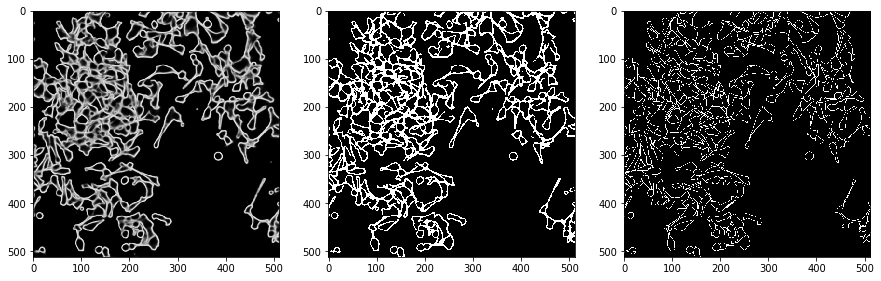

In [15]:
# Network output after training
maskshow(3)

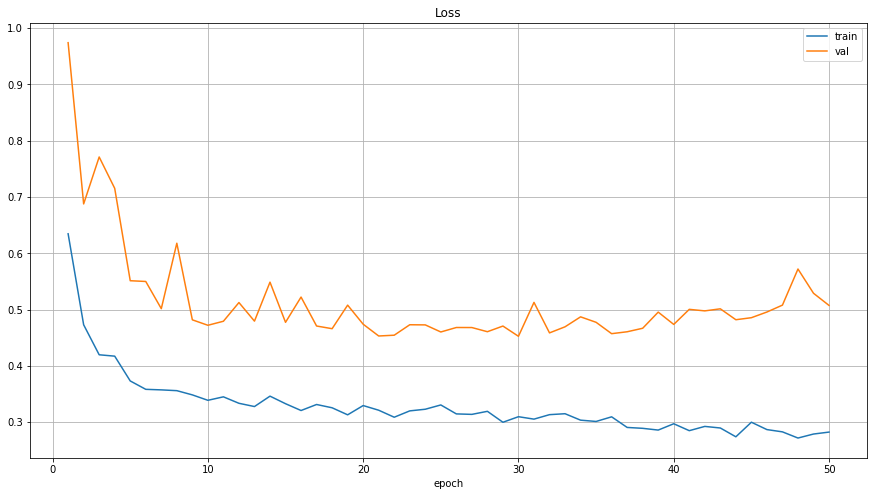

In [16]:
plt.figure(figsize=(15,8))
plt.plot(np.arange(1,1+len(loss_history['train'])), loss_history['train'], label='train')
plt.plot(np.arange(1,1+len(loss_history['val'])), loss_history['val'], label='val')
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
# plt.ylim(.37, .45)
plt.show()

In [17]:
def val_iou(model, threshold):
    model.eval()
    
    predictions = []
    ground_truths = []
    # Iterate over data.
    for inputs, masks in dataloaders['val']:
        inputs = inputs.to(device)
        masks = masks.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            
        # Store masks to calculate IoU for the whole epoch
        predicted_mask = (outputs.detach().sigmoid() >= threshold).cpu().numpy()
        masks = masks.cpu().numpy()
        predictions.append(predicted_mask)
        ground_truths.append(masks)

    predictions = np.concatenate(predictions)
    ground_truths = np.concatenate(ground_truths)
    return calc_iou(predictions, ground_truths)

def best_threshold_iou(model, plot=False):
    n = 101
    threshold = np.linspace(0, 1, num=n)
    iou = np.zeros(n)
    for i in range(n):
        iou[i] = val_iou(model, threshold[i])
    
    if plot == True:
        plt.figure(figsize=(15,8))
        plt.plot(threshold, iou, ".-g")
        plt.title('IoU vs threshold')
        plt.xlabel('Threshold')
        plt.ylabel('IoU')
        plt.grid()
        plt.show()
        
    i_best = np.argmax(iou)
    print("Best threshold: %.3f, best IoU: %.6f" % (threshold[i_best], iou[i_best]))
    return threshold[i_best], iou[i_best]

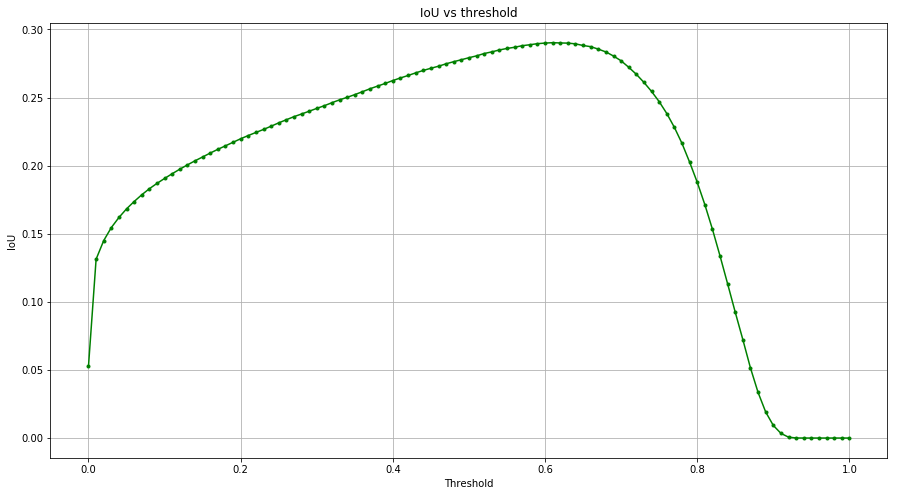

Best threshold: 0.610, best IoU: 0.290284


In [18]:
threshold_best, iou_best = best_threshold_iou(net, plot=True)

In [21]:
### Save the net
# torch.save(net.state_dict(), 'unet_dict.pth.tar')
# loss = np.concatenate((np.array(loss_history['train'])[:, None], np.array(loss_history['val'])[:, None]), axis=1)
# np.savetxt('unet_loss.txt', loss)

In [12]:
### Load the net
# net = UNet(pretrained_encoder=True)

# # load the model
# net.load_state_dict(torch.load('unet_dict.pth.tar'))
# net = net.to(device)

# # load the loss history
# loss_history_np = np.loadtxt('unet_loss.txt')
# loss_history = {'train': list(loss_history_np[:,0]), 'val': list(loss_history_np[:,1])}

In [45]:
### Save the test masks

test_images = glob.glob('./BBBC018_v1_images-fixed/test/*.bmp')

to_tensor = T.ToTensor()
to_image = T.ToPILImage()

tensors = []
for image_path in test_images:
    image = Image.open(image_path)
    tensors.append(to_tensor(image)[None, ...])
tensors = torch.cat(tensors).to(device)

net.eval()
with torch.no_grad():
    masks = net(tensors).sigmoid()

for i in range(masks.shape[0]):
    image = to_image((masks[i] > threshold_best).cpu().float())
    image.save('./segmentation_test/' + os.path.basename(test_images[i])[:-7] + 'png')

### Summary
The final model is a UNet with some layers pretrained (from the ImageNet-pretrained VGG13_bn), trained with binary cross-entropy loss and some data-augmentations (flips and colorjitter). Its output has one channel. Other things like random affine augmentations and rotations worked a little worse in my experiments. I also tried jaccard (soft-IoU) loss and it resulted in similar IoU after training, but the detected cell edges in the output (logit maps) were less blurry. So, when I tried tuning the threshold "probability" for classifying a pixel as a cell edge, it worked better after training with cross entropy loss. Also, pos_weight > 1 (10, for the final model) was used to deal with the data imbalance. The final model's IoU was 0.2792 after training (with threshold = .5) and 0.2903 after threshold tuning (with threshold = .61) which satisfies the requirement.